In [23]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool, shared_memory
import os
import numpy as np
import matplotlib.pyplot as plt

    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *

from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from pde_solvers.cn import *

In [2]:
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

# Load parameters

In [5]:
import pandas as pd
df = pd.read_csv("../with_diffusions_second_search/df_network_analysis_full_topology_with_estimates.csv")
df["index"] = range(df.shape[0])

In [11]:
def load_dataset(path, cont=False):
    if cont:
        with open(f"../{path[:-4]}_2", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    else:
        with open(f"../{path}", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [7]:
def to(arr):
    return arr.reshape(128, 128) 

In [8]:
def get_df_param(index):
    (n_val,
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = df.iloc[index]["params"]
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return params

In [9]:
from scipy.optimize import minimize

def rosenbrock(x1, x2, a=1, b=100):
    return (a-x1)**2 + b*(x2 - x1**2)**2

def alienor_components(epsilon, l1, bounds, ):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b, 1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i-1]
        # (pi/alpha)^(i-1) (b_i - a_i)
        alphas[i] = np.pi*alphas[i-1]*(b-a)/alpha
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2
        a,b = bounds[i]
        h_i = get_h_i(a,b, alphas[i])
        h_list.append(h_i)
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(d[1]-d[0])**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    theta_max = np.pi/alphas[0]
    return alpha, alphas, l2, h_list, theta_max

def minim(epsilon, l1, bounds, func, maxiter=10,method="Nelder-Mead"):
    alpha, alphas, l2, h_list, theta_max = alienor_components(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    
    theta = theta_max/2#np.pi/(2*alphas[0])  
    bounds=[(0, theta_max)]
    
    theta_epsilon = theta
    f = lambda t: func(*[ h(t) for h in h_list])
    
    f_epsilon = f(theta_epsilon)
    F_epsilon = f_epsilon - L*theta_max/2
    def single_F_k(f_theta, theta):
        def F_k(t):
            return f_theta - L*np.abs(theta - t)
        return F_k
    
    def get_F_k_func(F_k_list):
        def F_k_func(t):
            return np.max([f_i(t) for f_i in F_k_list])
        return F_k_func
    
    def get_F_k_func_vec(f_epsilon_arr, theta_arr):
        def F_k_func(t):
            return np.max(f_epsilon_arr - L*np.abs(theta_arr - t))
        return F_k_func
            
    theta_arr = np.array([theta])
    f_epsilon_arr = np.array([f_epsilon]) 
    F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
    res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                   bounds=bounds,  method=method)    
    theta = res['x'][0]        
    f_theta  =  f(theta)
    while k < maxiter:
        if f_epsilon - F_epsilon <= epsilon/2:            
            return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, "")
        
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        
        theta_arr = np.concatenate([theta_arr, [theta]])
        f_epsilon_arr = np.concatenate([f_epsilon_arr, [f_epsilon]]) 
        F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
        res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                       bounds=bounds,  method=method)
        
        theta = res['x'][0] 
        f_theta  =  f(theta)
        F_epsilon = res['fun']
        k += 1    
    return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached")

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [10]:
df[df["index"] == 10]["path"]

10    outputs_second_search/solution_10_10_103.npy
Name: path, dtype: object

In [35]:
run_index = 10
path = df[df["index"] == run_index]["path"][run_index]
#print(path)
print(run_index, path, df["bad_estimates"].iloc[run_index])
(params, res, k_max) = load_dataset(path)
with open(f"./index_{run_index}_noise_5.npy", "rb") as f:
    data_output = np.load(f)

A = data_output[0, ...]
B = data_output[1, ...]
C = data_output[2, ...]

def Create_f_A(A, B, C, n, mu_A):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]    
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
    A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]

    def L_2_f_a(args):
        (D_A, b_A, V_A,  K_AA, K_BA
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_A_1_D(A, B, C, n, mu_A):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]    
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
    A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]
    def L_2_f_a(args):        
        (D_A, b_A,V_A, K_AA, K_BA
        ) = (args[0], args[1], args[2], args[3], args[4])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_B(A, B, C, n, mu_B):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
    B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]    
    def L_2_f_b(args):
        (D_B, b_B, V_B, K_AB, K_CB
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_B_1_D(A, B, C, n, mu_B):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
    B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]
    def L_2_f_b(args):        
        (D_B, b_B, V_B,K_AB, K_CB
        )  = (args[0], args[1], args[2], args[3], args[4])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_C(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    def L_2_f_c(args):
        b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
        #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2, axis=1)
    return L_2_f_c

def Create_f_C_1_D(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    def L_2_f_c(args):        
        b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2)
    return L_2_f_c

f_a_loss = Create_f_A(A, B, C, 4, params["mu_A"])
f_a_loss_1_D = Create_f_A_1_D(A, B, C, 4, params["mu_A"])
f_b_loss = Create_f_B(A, B, C, 4, params["mu_B"])
f_b_loss_1_D = Create_f_B_1_D(A, B, C, 4, params["mu_B"])
f_c_loss = Create_f_C(A, B, C, 4, params["mu_C"])
f_c_loss_1_D = Create_f_C_1_D(A, B, C, 4, params["mu_C"])

print("original f_a loss:", 
      f_a_loss(
          np.array([[params["D_A"], params["b_A"], params["V_A"],
                     params["K_AA"], params["K_BA"]]]))
     )
print("original f_b loss:", 
      f_b_loss(
          np.array([[params["D_B"], params["b_B"], params["V_B"],
                     params["K_AB"], params["K_CB"]]]))
     )
print("original f_c loss:", 
      f_c_loss(
          np.array([[params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"]]]))
     )

bounds_A = [(0,10), (0,30), (0,200), (0,30), (0,30)]
bounds_B = [(0,10), (0,30), (0,200), (0,30), (0,30)]
bounds_C = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilon = 1e-3
l1 = 1

alpha_A, alphas_A, l2_A, h_list2_A, theta_max2_A = alienor_components2(epsilon, l1, bounds_A)
alpha_B, alphas_B, l2_B, h_list2_B, theta_max2_B = alienor_components2(epsilon, l1, bounds_B)
alpha_C, alphas_C, l2_C, h_list2_C, theta_max2_C = alienor_components2(epsilon, l1, bounds_C)
L_A = l1*l2_A
L_B = l1*l2_B
L_C = l1*l2_C
print("delta theta A:", epsilon/L_A)
print("delta theta A:", L_A/epsilon)
print()
print("delta theta B:", epsilon/L_B)
print("delta theta B:", L_B/epsilon)
print()
print("delta theta C:", epsilon/L_C)
print("delta theta C:", L_C/epsilon)

batch_size = 10000
print("A epochs:", L_A/epsilon/batch_size)
print("B epochs:", L_B/epsilon/batch_size)
print("C epochs:", L_C/epsilon/batch_size)

thetas_A = np.linspace(0, theta_max2_A,  int(L_A/epsilon))
thetas_B = np.linspace(0, theta_max2_B,  int(L_B/epsilon))
thetas_C = np.linspace(0, theta_max2_C,  int(L_C/epsilon))

params_by_theta_A = np.stack([h_list2_A[0](thetas_A), h_list2_A[1](thetas_A),
                              h_list2_A[2](thetas_A), h_list2_A[3](thetas_A),
                              h_list2_A[4](thetas_A)]).T

params_by_theta_B = np.stack([h_list2_B[0](thetas_B), h_list2_B[1](thetas_B),
                              h_list2_B[2](thetas_B), h_list2_B[3](thetas_B),
                              h_list2_B[4](thetas_B)]).T

params_by_theta_C = np.stack([h_list2_C[0](thetas_C), h_list2_C[1](thetas_C),
                              h_list2_C[2](thetas_C), h_list2_C[3](thetas_C),
                              h_list2_C[4](thetas_C)]).T

theta_A_n = params_by_theta_A.shape[0]
theta_A_m = params_by_theta_A.shape[1]
theta_B_n = params_by_theta_B.shape[0]
theta_B_m = params_by_theta_B.shape[1]
theta_C_n = params_by_theta_C.shape[0]
theta_C_m = params_by_theta_C.shape[1]

def singA(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta")
    output_shm = shared_memory.SharedMemory(name="outputs")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_a_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

def singB(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta")
    output_shm = shared_memory.SharedMemory(name="outputs")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_b_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

def singC(args):
    batch_id,theta_n,theta_m= args 
    params_shm = shared_memory.SharedMemory(name="params_by_theta")
    output_shm = shared_memory.SharedMemory(name="outputs")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

def run(theta_n,theta_m,params_by_theta, sing, L, epsilon, batch_size):
    shm = shared_memory.SharedMemory(name="params_by_theta",create=True, size=params_by_theta.nbytes)
    shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                                buffer=shm.buf)

    shared_thetas[:,:] = params_by_theta[:,:]


    f_thetas = np.zeros(theta_n)
    shm_out = shared_memory.SharedMemory(name="outputs",create=True, size=f_thetas.nbytes)
    shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                                 buffer=shm_out.buf)


    args =[ (batch_id, theta_n,theta_m) for batch_id in range(int(L/epsilon/batch_size) + 1)]

    with Pool(55) as pool:
        res = pool.map(sing, args)

    f_thetas[:] = shared_outputs[:]
    shm.close()
    shm.unlink()

    shm_out.close()
    shm_out.unlink()

    return f_thetas




f_thetas_A = run(theta_A_n,theta_A_m,params_by_theta_A, singA, L_A, epsilon, batch_size)
f_thetas_B = run(theta_B_n,theta_B_m,params_by_theta_B, singB, L_B, epsilon, batch_size)
f_thetas_C = run(theta_C_n,theta_C_m,params_by_theta_C, singC, L_C, epsilon, batch_size)


def minimise_top_n(n, h_list, bounds, loss_1_D, f_thetas, thetas):
    shift = 0
    init_params = np.zeros((n, len(h_list)))
    final_params = np.zeros((n, len(h_list)))
    init_loss = np.zeros(n)
    final_loss = np.zeros(n)

    top_n = np.argpartition(-f_thetas, -n)[-n:]
    top_n = top_n[np.argsort(f_thetas[top_n])]

    for shift in range(n):

        theta_star = thetas[top_n][0 + shift]
        init_par = tuple([h(theta_star) for h in h_list])
        init_params[shift, :] = init_par
        init_loss[shift] = f_thetas[top_n][0 + shift]
        #bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
        res3= minimize(loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
        final_params[shift, :] = res3['x']
        final_loss[shift] = res3['fun']

    sorted_loss_ind = np.argsort(final_loss)
    init_params = init_params[sorted_loss_ind.tolist()]
    init_loss = init_loss[sorted_loss_ind.tolist()]
    final_params = final_params[sorted_loss_ind.tolist()]
    final_loss = final_loss[sorted_loss_ind.tolist()]

    return (final_loss, final_params, init_loss, init_params )

(final_loss_A, final_params_A, 
 init_loss_A, init_params_A) = minimise_top_n(10, h_list2_A, 
                                              ((0, 20), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_a_loss_1_D, f_thetas_A, thetas_A)

(final_loss_B, final_params_B, 
 init_loss_B, init_params_B) = minimise_top_n(10, h_list2_B, 
                                              ((0, 20), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_b_loss_1_D, f_thetas_B, thetas_B)

(final_loss_C, final_params_C, 
 init_loss_C, init_params_C) = minimise_top_n(10, h_list2_C, 
                                              ((0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                              f_c_loss_1_D, f_thetas_C, thetas_C)

for i, (a,b,c,d) in enumerate(zip(final_loss_A, final_params_A,init_loss_A, init_params_A)):
    print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
    print()
    print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
    print("="*40)

for i, (a,b,c,d) in enumerate(zip(final_loss_B, final_params_B,init_loss_B, init_params_B)):
    print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
    print()
    print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
    print("="*40)

for i, (a,b,c,d) in enumerate(zip(final_loss_C, final_params_C,init_loss_C, init_params_C)):
    print(i, f"final loss:{a:.8f}, params:{','.join([f'{value:.8f}' for value in b])}")
    print()
    print(i, f"init loss:{c:.8f}, params:{','.join([f'{value:.8f}' for value in d])}")
    print("="*40)
    

     

10 outputs_second_search/solution_10_10_103.npy 2
original f_a loss: [20024.59956532]
original f_b loss: [5169.72553468]
original f_c loss: [0.02464989]
delta theta A: 2e-05
delta theta A: 50000.0

delta theta B: 2e-05
delta theta B: 50000.0

delta theta C: 2.222222222222222e-06
delta theta C: 450000.0
A epochs: 5.0
B epochs: 5.0
C epochs: 45.0
0 final loss:20733.94921875, params:0.04713516,0.00530762,192.44508405,13.38198763,21.60809587

0 init loss:23732.05594377, params:0.14140524,0.00530762,192.44508405,13.38198763,21.60809587
1 final loss:21465.55273438, params:0.07548783,0.15030840,112.60571700,11.37981456,29.98490747

1 init loss:22640.88024282, params:0.11323149,0.15030840,112.60571700,11.37981456,29.98490747
2 final loss:22017.85156250, params:0.06731317,1.02227645,194.67189421,13.34128947,22.20454059

2 init loss:22290.15068190, params:0.04578271,1.02227645,194.67189421,13.34128947,22.20454059
3 final loss:22278.97460938, params:0.08636217,0.88250156,91.67411852,10.79162783,2

In [36]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

D_A:0.01, D_B:1.0, b_A:0.0010, mu_A:1.0000, V_A:20.0000, K_AA:5.0000, K_AB:5.0000, K_AC:10.0000, b_B:0.1000, mu_B:5.0000, V_B:100.0000, K_BA:10.0000, K_BC:5.0000, b_C:1.0000, mu_C:0.5000, V_C:100.0000, K_CB:10.0000, K_CC:10.0000
D_A:0.0471, D_B:0.2273, b_A:0.0053, mu_A:1.0000, V_A:192.4451, K_AA:13.3820, K_AB:4.4471, K_AC:28.2989, b_B:27.1103, mu_B:5.0000, V_B:61.3230, K_BA:21.6081, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:2.0947, K_CC:6.6822


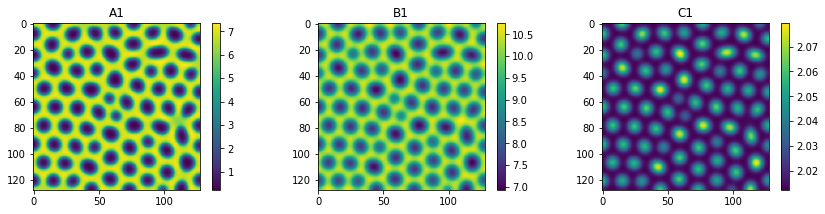

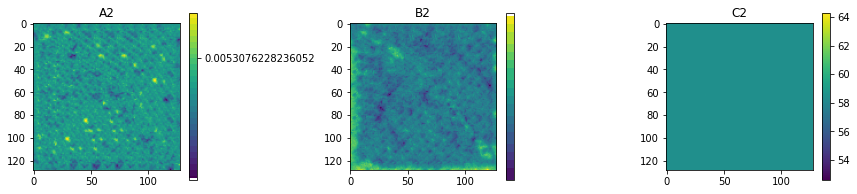

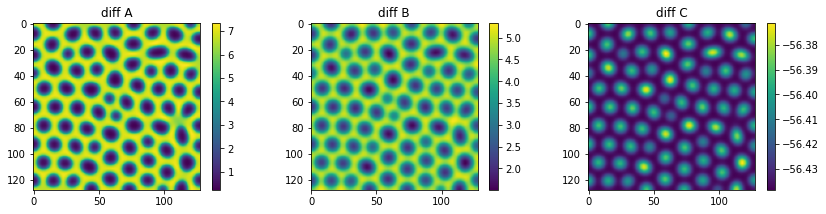

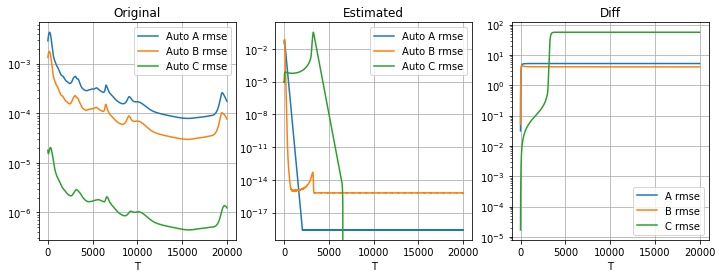

In [37]:
(_,_,n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params.values()

kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

A_init = res[0, 0, :]
B_init = res[0, 1, :]
C_init = res[0, 2, :]      
res_1 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 4*5000, 1)    
print(f"D_A:0.01, D_B:1.0, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
      f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
      f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
      f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
      f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
      f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")

def simulate_by(index, 
            final_params_A=final_params_A, 
            final_params_B=final_params_B, 
            final_params_C=final_params_C):
    D_A_val, b_A_val, V_A_val,  K_AA_val,  K_BA_val = final_params_A[index]
    D_B_val, b_B_val, V_B_val,  K_AB_val,  K_CB_val = final_params_B[index]
    b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = final_params_C[index]

#         print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
#                                        b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
#                                        b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)        
    print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
          f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
          f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
          f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
          f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
          f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
    kinetics = create_circuit_3954(n_val, 
                                   b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

    N=5000
    T=100
    delta_t = T/N
    model_128_10_2 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                                   Ix=128, Jy=128,
                                   boundary_condition=Neumann_Boundary_2D)
    res_2 = model_128_10_2.integrate([A_init,B_init,C_init], kinetics, 4*5000, 1)
    A1 = res_1[-1, 0, :]
    B1 = res_1[-1, 1, :]
    C1 = res_1[-1, 2, :]
    plot_n_im([to(A1), to(B1), to(C1)], 
                  ["A1", "B1", "C1"],          
                  figsize=(12, 3)); plt.tight_layout();plt.show()

    A2 = res_2[-1, 0, :]
    B2 = res_2[-1, 1, :]
    C2 = res_2[-1, 2, :] 
    plot_n_im([to(A2), to(B2), to(C2)], 
                  ["A2", "B2", "C2"],          
                  figsize=(12, 3)); plt.tight_layout();plt.show()

    plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
                  ["diff A", "diff B", "diff C"],          
                  figsize=(12, 3)); plt.tight_layout();plt.show()
    def RMSE(a1, a2):
        return np.sqrt(np.mean((a1-a2)**2, axis=1))
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
    plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
    plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
    plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

    plt.subplot(132)
    plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
    plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
    plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
    plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

    plt.subplot(133)
    plt.plot(RMSE(res_1[:, 0, :], res_2[:, 0, :]) , label="A rmse")
    plt.plot(RMSE(res_1[:, 1, :], res_2[:, 1, :]) , label="B rmse")
    plt.plot(RMSE(res_1[:, 2, :], res_2[:, 2, :]) , label="C rmse")
    plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
    plt.show()
    return res_2


res_2 = simulate_by(0)
